# Analysis 4: How Interest Group Preferences Vary Across Industries.

In [1]:
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

from utils import open_csv, save_csv

##### Load the client-bill-label-level df with bill information

In [2]:
interest_group_bill_label_level_df = open_csv('analysis_input/analysis3_4_client_bill_label_bill_info_df.csv')
bill_score_party_df = open_csv('analysis_input/analysis4_bill_score_party_df.csv')

### Industry-wise Distribution of Interest Group Preferences

In [3]:
def final_boxplot_ideal_point_by_code(df):
    plot_code = 'industry'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue' ,'red'])

    # Calculate median ideal_point_standard for each sector
    median_values = df.groupby(plot_code)['ideal_point_standard'].median()
    
    # Calculate counts of each sector
    count_values = df[plot_code].value_counts()
    
    # Filter out sectors with fewer than 10 samples
    valid_codes = count_values[count_values >= 0].index

    # Filter median and count values to include only valid codes
    median_values = median_values[valid_codes]
    count_values = count_values[valid_codes]

    # Sort sectors by median ideal_point_standard in descending order
    sorted_codes = median_values.sort_values(ascending=False).index

    # Create labels with counts
    labels_with_counts = [f"{code}" for code in sorted_codes]
    
    # Normalize median values to get colors from the colormap
    norm = plt.Normalize(median_values.min(), median_values.max())
    colors = [cmap(norm(median_values[code])) for code in sorted_codes]

    # Create boxplot with sectors sorted by median ideal_point_standard
    plt.figure(figsize=(4, len(sorted_codes)*0.28))
    boxplot = sns.boxplot(data=df, y=plot_code, x='ideal_point_standard', order=sorted_codes, palette=colors)
    
    # Set y-tick labels with counts
    boxplot.set_yticklabels(labels_with_counts, fontsize=10)
    plt.yticks(rotation=0)  # Rotate sector labels for better readability
    # plt.title(f'{plot_code}')
    # plt.xlabel('Interest Group')
    plt.xlabel('Lobbying Position Score')
    plt.ylabel('Industry')
    plt.legend().set_visible(False)
    
    # Adjust the colors of the boxes
    for patch, color in zip(boxplot.artists, colors):
        patch.set_facecolor(color)

    # Specify the y-axis labels you want to highlight
    highlight_labels = selected_industies
    
    # Get current y-tick labels
    ytick_labels = boxplot.get_yticklabels()
    
    # Loop through the labels to highlight
    for label in ytick_labels:
        if label.get_text() in highlight_labels:
            if label.get_text() in ['Gun Control', 'Gun Rights']:
                label.set_bbox(dict(facecolor='None', edgecolor='orange', boxstyle='round,pad=0.3'))
            elif label.get_text() in ['Abortion Policy/Anti-Abortion','Abortion Policy/Pro-Abortion Rights']:
                label.set_bbox(dict(facecolor='None', edgecolor='hotpink', boxstyle='round,pad=0.3'))
            elif label.get_text() in ['Democratic/Liberal','Republican/Conservative']:
                label.set_bbox(dict(facecolor='None', edgecolor='mediumpurple', boxstyle='round,pad=0.1'))

    plt.grid(True, axis='x', linestyle='--', linewidth=0.3, color='gray')
    plt.grid(True, axis='y', linestyle='--', linewidth=0.3, color='gray')
    os.makedirs('analysis_output', exist_ok=True)
    plt.savefig(f'analysis_output/analysis4_fig5.pdf', format='pdf', bbox_inches='tight')
    plt.show()


## Fig. 5. Industry-wise Distribution of Interest Group Preferences.

/tmp/ipykernel_6358/3554656902.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(data=df, y=plot_code, x='ideal_point_standard', order=sorted_codes, palette=colors)
/tmp/ipykernel_6358/3554656902.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_yticklabels(labels_with_counts, fontsize=10)
/tmp/ipykernel_6358/3554656902.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


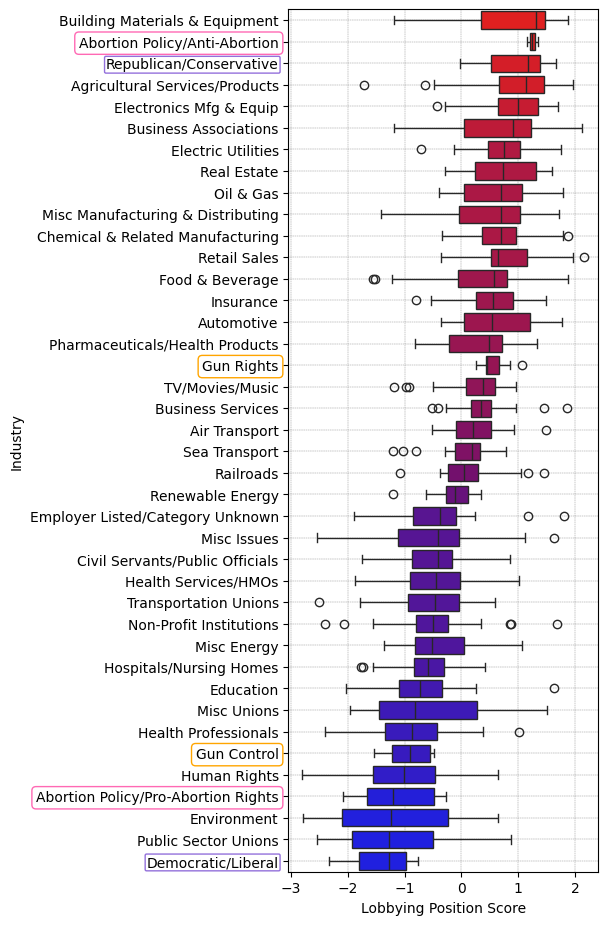

In [4]:
# select 40 industries with the most common interest groups 
selected_industies = [
'Abortion Policy/Anti-Abortion',
'Abortion Policy/Pro-Abortion Rights',
'Democratic/Liberal',
'Republican/Conservative',
'Gun Control',
'Gun Rights',
]

industry_df_boxplot = interest_group_bill_label_level_df.groupby('industry').filter(\
    lambda x: (x['lob_id'].nunique() >= 15 or x['industry'].iloc[0] in selected_industies) and x['industry'].iloc[0] != 'Other').drop_duplicates(subset=['lob_id'])

# plot industry boxplot
final_boxplot_ideal_point_by_code(industry_df_boxplot)

## Fig. 6. Bill-Level Distribution of Positions Across Interest Groups (A). & 

In [5]:
def kdeplot_bill_interest_group_score(df):

    color_dict = {
    'Support': '#01897b',
    'Oppose': '#e6447b',
    'Engage': '#D3D3D3'
    }
    df_clean = df.dropna(subset=['ideal_point_standard'])

    x_min = df_clean['ideal_point_standard'].min()*1.4
    x_max = df_clean['ideal_point_standard'].max()*1.4
        
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    axes = axes.flatten()
    
    # Loop through unique labels and plot in separate subplots
    for i, label in enumerate(sorted(df_clean['label'].unique())):
        subset = df_clean[df_clean['label'] == label]
        label_name = subset['label_name'].iloc[0]
        
        # 2D KDE Plot on the i-th subplot with specific colors
        sns.kdeplot(
            x=subset['ideal_point_standard'], 
            y=subset['bill_point_standard'], 
            fill=True, 
            ax=axes[i],
            color=color_dict[label_name]
        )
    
        # Set titles and labels for each subplot
        axes[i].set_xlim(x_min, x_max)    
        axes[i].tick_params(axis='both', labelsize=20)
        axes[i].set_title(f'{label_name}', fontsize=20)
        axes[i].set_xlabel('', fontsize=20)
        axes[i].set_ylabel("Bill Latent Score", fontsize=20)
    fig.text(0.52, -0.02, 'Lobbying Position Score', ha='center', fontsize=20)
    # Adjust layout
    plt.tight_layout()
    os.makedirs('analysis_output', exist_ok=True)
    plt.savefig(f'analysis_output/analysis4_fig6_a.pdf', format='pdf', bbox_inches='tight',pad_inches=0.2)
    plt.show()


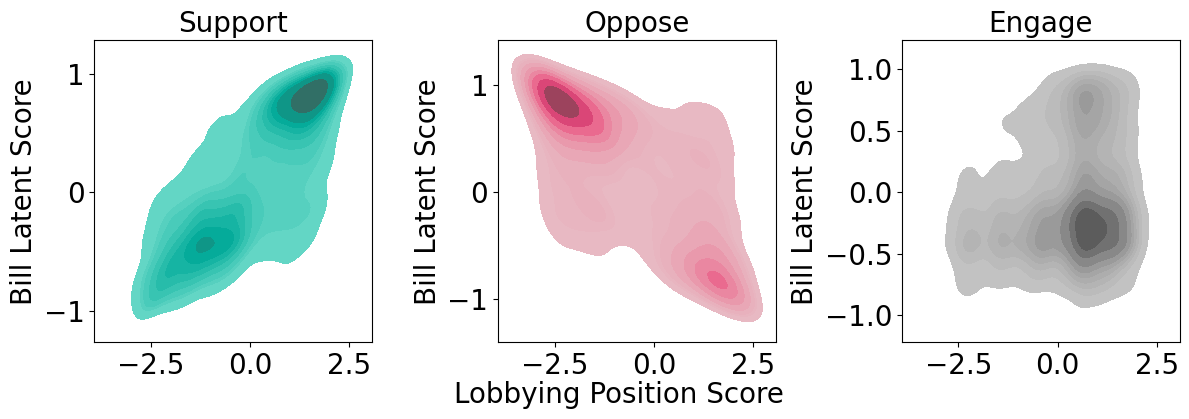

In [6]:
kdeplot_bill_interest_group_score(interest_group_bill_label_level_df)

## Fig. 6. Bill-Level Distribution of Positions Across Interest Groups (B), (C), and (D)

In [7]:
def format_bill_strings(selected_bill):
    bill_id, nth_congress = selected_bill.split('-')[0], selected_bill.split('-')[-1]
    bill_id = bill_id.upper()
    formatted_bill = re.sub(r'HR(\d+)', r'H.R.\1', bill_id)
    formatted_bill = re.sub(r'S(\d+)', r'S.\1', formatted_bill)
    bill_id_title = f'{formatted_bill} ({nth_congress}th Congress)'
    return bill_id_title


def plot_one_bill_industry_bill_position(df, name, selected_bill):
    color_dict = {
        'Support': '#01897b',
        'Oppose': '#e6447b',
        'Engage': '#969696'
    }

    bill_id_title = format_bill_strings(selected_bill)

    # get selected bill information
    filtered_df = df[df['bill_id'] == selected_bill]
    short_title = df[df['bill_id'] == selected_bill]['short_title'].values[0]
    official_title = df[df['bill_id'] == selected_bill]['official_title'].values[0]
    bill_subject = df[df['bill_id'] == selected_bill]['subjects_top_term'].values[0]
    bill_subjects = df[df['bill_id'] == selected_bill]['subjects'].values[0]
    count_df = filtered_df.groupby(['industry', 'label_name']).size().reset_index(name='count')

    # set industry order
    all_industry_order = (
        filtered_df.groupby('industry')['ideal_point_standard']
        .mean()
        .sort_values(ascending=True)
        .index
    )
    
    industries = filtered_df['industry'].unique()
    
    # Create a dictionary to map industries to their order in all_industry_order
    industry_order_dict = {industry: idx for idx, industry in enumerate(all_industry_order)}
    
    # Apply the mapping to filtered_df
    filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
    
    # Create a list of industries in the same order as all_industry_order, but only for the industries in filtered_df
    industry_order = [industry for industry in all_industry_order if industry in industries]
    max_label_len = max(len(label) for label in industry_order)

    fig_width = max(4, max_label_len * 0.2)
    fig_height = max(4, len(industry_order) * 0.3)

    plt.figure(figsize=(fig_width,fig_height))

    # Mark a point for each industry
    for idx, industry in enumerate(industry_order):
        industry_data = filtered_df[filtered_df['industry'] == industry]
        sns.scatterplot(
            data=industry_data,
            x='ideal_point_standard',
            y=[idx] * len(industry_data),  # Place the points horizontally using the same y-value
            hue='label_name',
            palette=color_dict,
            marker='o',
            s=40,
            alpha=0.7,
            legend=False
        )

        # Draw light gray horizontal lines corresponding to each industry
        industry_avg = industry_data['ideal_point_standard'].mean()
        plt.axhline(y=idx, color='gray', linestyle='-', alpha=0.1)


    plt.xlim(-3, 3)
    plt.yticks(range(len(industry_order)), industry_order)#, fontsize=11)
    plt.title(f'{bill_id_title}\n{short_title}\n({bill_subject})', fontsize=11)
    plt.xlabel('Lobbying Position Score', fontsize=12)
    plt.ylabel('Industry', fontsize=12)
    

    handles = [
        mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2) 
        for label in color_dict if label in ['Support','Oppose','Engage']
    ]

    plt.tight_layout()
    os.makedirs('analysis_output', exist_ok=True)
    plt.savefig(f'analysis_output/{name}_{selected_bill}.pdf', format='pdf', bbox_inches='tight')
    plt.show()



## Fig. 6. Bill-Level Distribution of Positions Across Interest Groups (B), (C), and (D)

#### analysis4_fig6_b

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


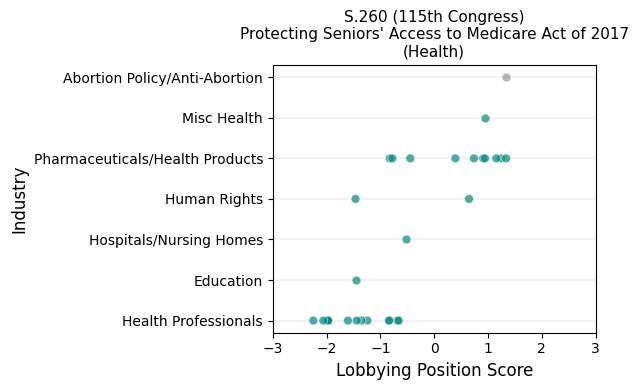

In [8]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig6_b', 's260-115')

#### analysis4_fig6_c

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


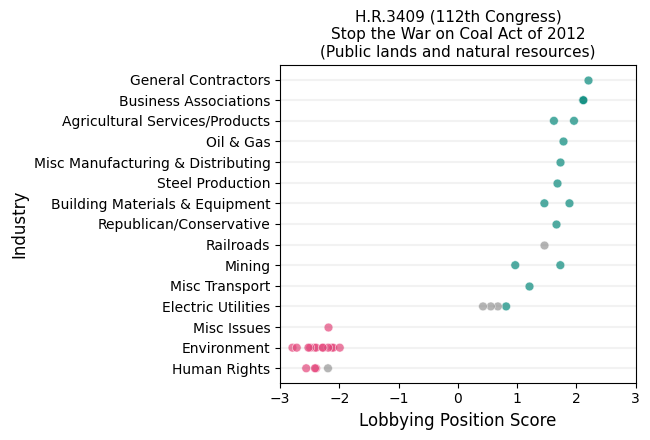

In [9]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig6_c', 'hr3409-112')

#### analysis4_fig6_d

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


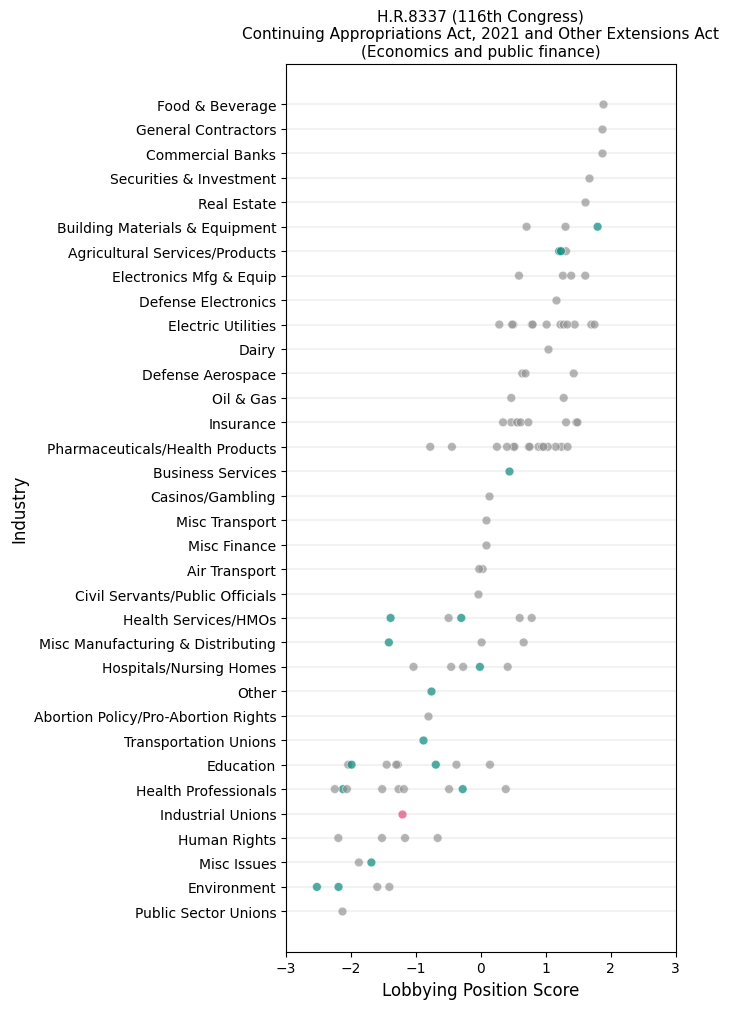

In [10]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig6_d', 'hr8337-116')

## Fig. 9. Bills with high Support ratios, illustrating bill positions across industries (analysis4_fig9_appendix)

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


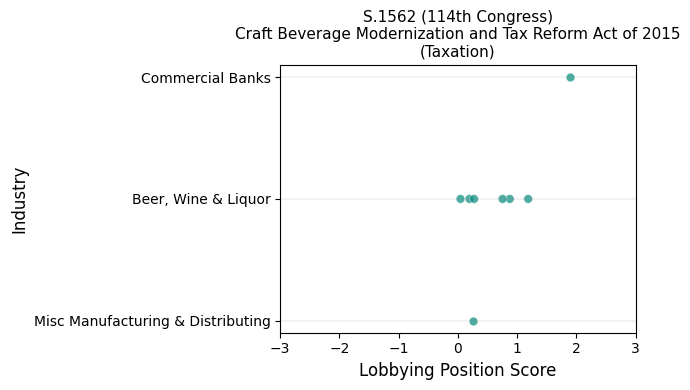

In [11]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig9_appendix_1', 's1562-114')

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


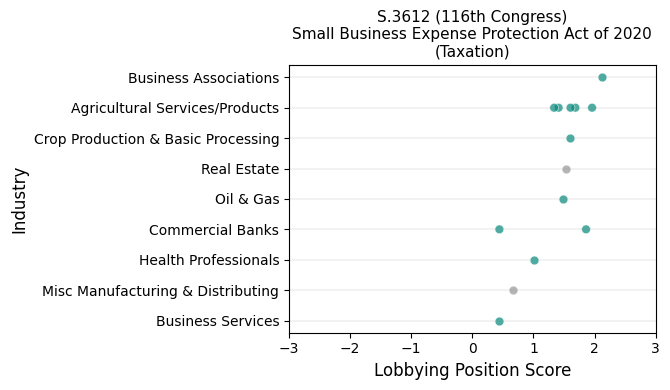

In [12]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig9_appendix_2', 's3612-116')

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


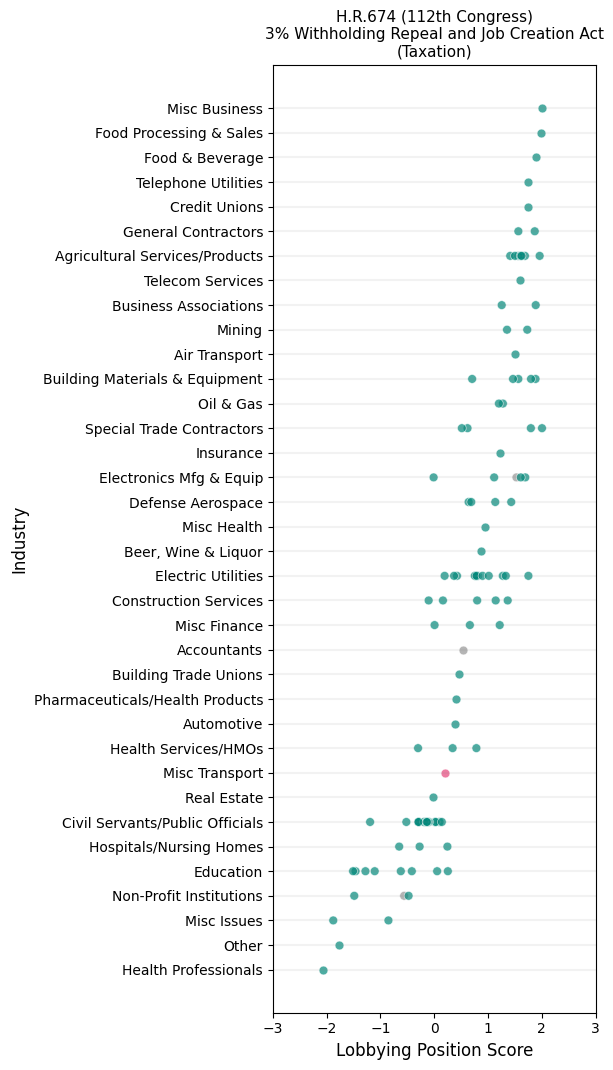

In [13]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig9_appendix_3', 'hr674-112')

## Fig. 10. Bills with high Oppose ratios, illustrating bill positions across industries (analysis4_fig10_appendix)

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


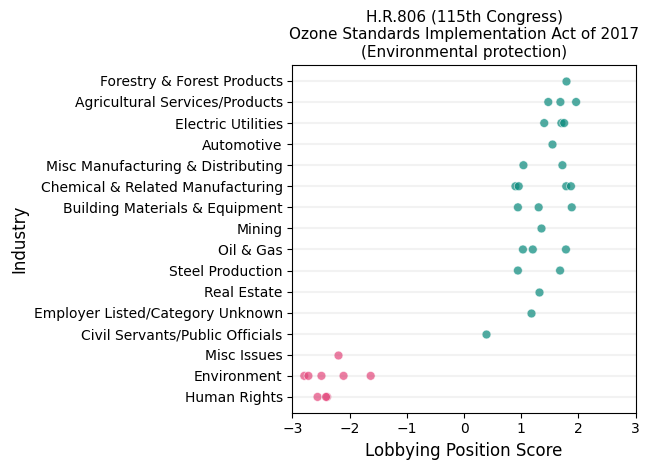

In [14]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig10_appendix_1', 'hr806-115')

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


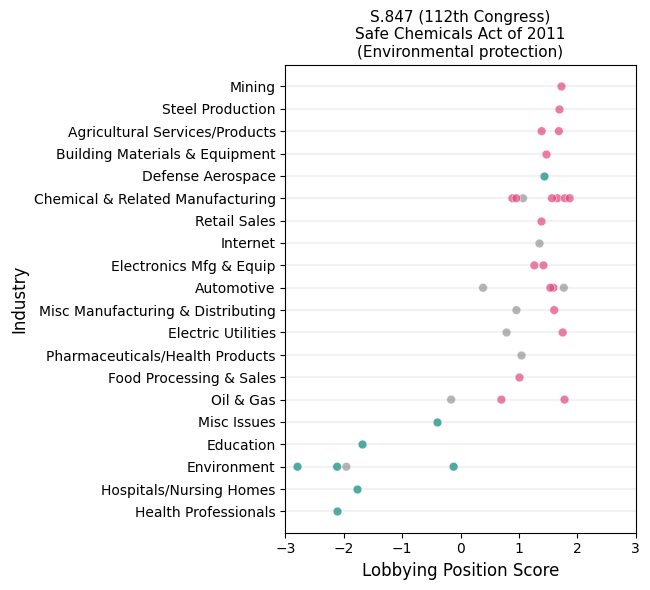

In [15]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig10_appendix_2', 's847-112')

## Fig. 11. Bills with high Engage ratios, illustrating bill positions across industries (analysis4_fig11_appendix)

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


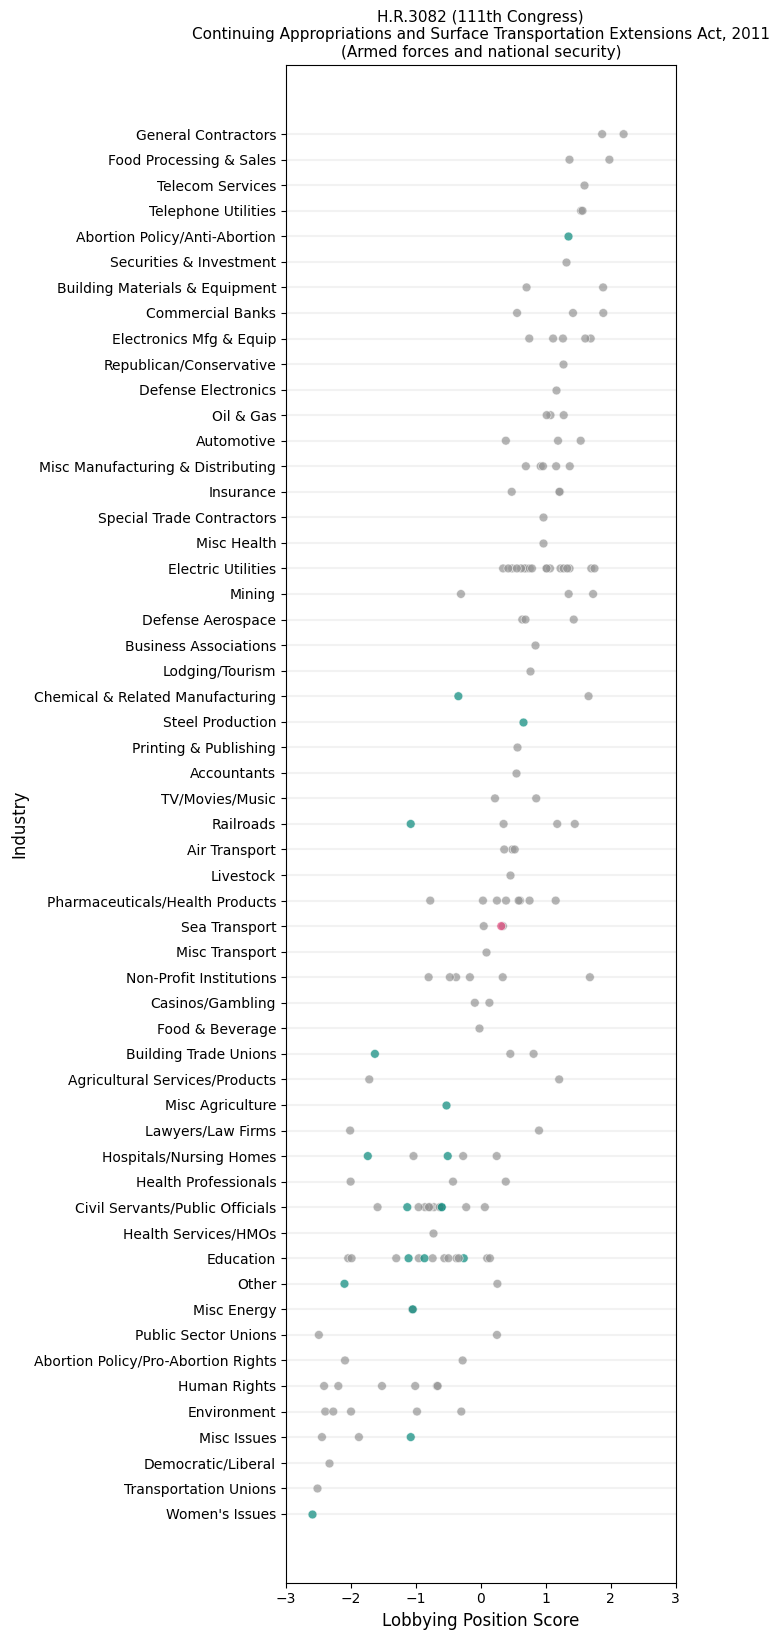

In [16]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig11_appendix_1', 'hr3082-111')

/tmp/ipykernel_6358/2814414075.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['industry_order'] = filtered_df['industry'].apply(lambda x: industry_order_dict.get(x, -1))  # Use -1 for missing industries, if needed
/tmp/ipykernel_6358/2814414075.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_dict[label], label=label, alpha=0.7, edgecolor=color_dict[label], linewidth=2)


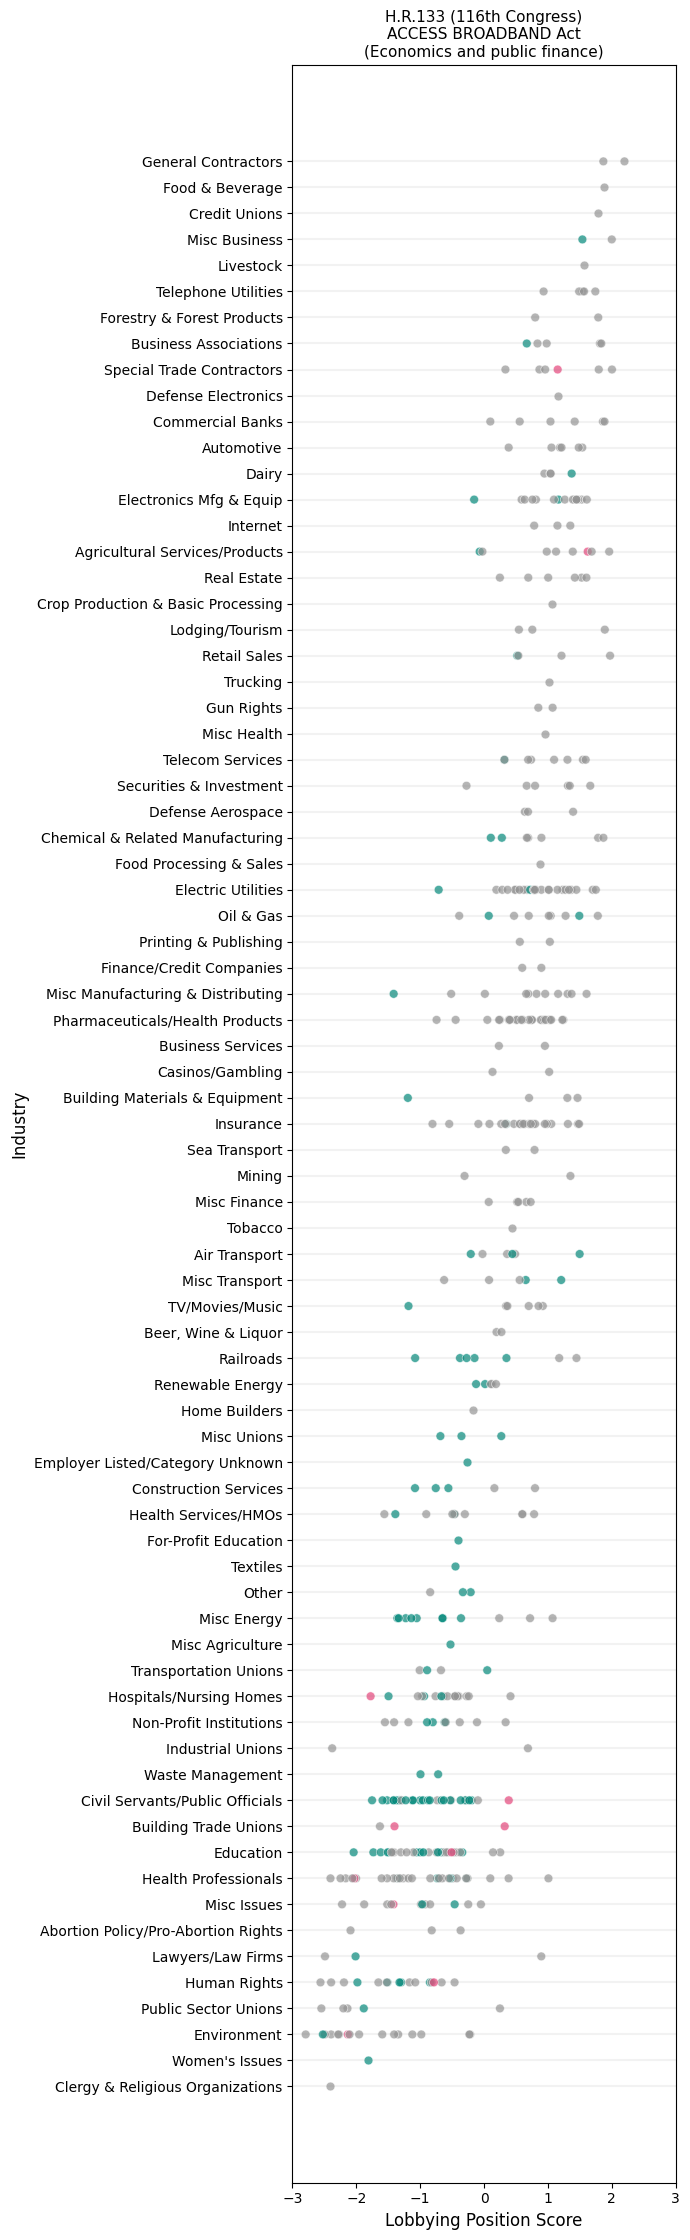

In [17]:
plot_one_bill_industry_bill_position(interest_group_bill_label_level_df, 'analysis4_fig11_appendix_1', 'hr133-116')

## Fig. 12. Sponsor party’s distribution of the bill’s latent score (appendix)

In [18]:
def get_bill_score_party_distribution(bill_score_party_df):
    palette = {"Democrat": "blue", "Republican": "red","Independent": "gray"}
    plt.figure(figsize=(8, 6))
    sns.histplot(data=bill_score_party_df, x="bill_point_standard", hue="Party", kde=True, bins=50, alpha=0.5, palette=palette)#, edgecolor=None)
    
    plt.title("Distribution of Bill latent score by Sonspor's Party", fontsize=15)
    plt.xlabel("Bill Latent Score", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    
    plt.tight_layout()
    os.makedirs('analysis_output', exist_ok=True)
    plt.savefig(f'analysis_output/analysis4_fig12_appendix.pdf', format='pdf')
    plt.show()


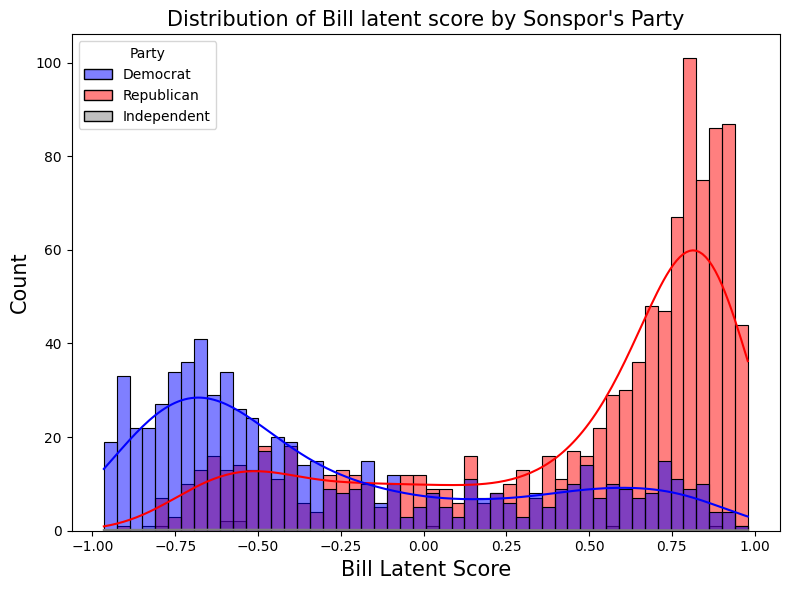

In [19]:
get_bill_score_party_distribution(bill_score_party_df)